#### A/B-тестирование приложения доставки для курьеров 

У нас есть несколько ресторанов в разных частях города и целый штат курьеров. Но есть одна проблема — к вечеру скорость доставки падает из-за того, что курьеры уходят домой после рабочего дня, а количество заказов лишь растёт. Это приводит к тому, что в момент пересмены наша доставка очень сильно проседает в эффективности. 

Наши data scientist-ы придумали новый алгоритм, который позволяет курьерам запланировать свои последние заказы перед окончанием рабочего дня так, чтобы их маршрут доставки совпадал с маршрутом до дома. То есть, чтобы курьеры доставляли последние свои заказы за день как бы "по пути" домой. 

Команда решила раскатить A/B тест на две равные группы курьеров. Часть курьеров использует старый алгоритм без опции "по пути", другие видят в своем приложении эту опцию и могут ее выбрать. 
**Наша задача – проанализировать данные эксперимента и помочь бизнесу принять решение о раскатке новой фичи на всех курьеров**.

###### Описание данных:
- **order_id** - id заказа
- **delivery_time** - время доставки в минутах
- **district** - район доставки
- **experiment_group** - экспериментальная группа

In [1]:
# импортируем нужные библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import scipy.stats as st
import statsmodels.stats.api as sms

In [2]:
# задаём настройки графиков
sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(15,7)}
        )

In [4]:
# загружаем данные и смотрим на них
experiment = pd.read_csv('C:/Users/Lenovo/Desktop/Портфолио/Datas/abexperiment.csv')
experiment.head()

,order_id,delivery_time,district,experiment_group
0,3159,44.0,Purlieus,control
1,10426,51.0,Purlieus,control
2,9155,46.0,Purlieus,control
3,10699,34.0,Purlieus,control
4,10061,43.0,Purlieus,control


In [5]:
# посмотрим на типы данных
experiment.dtypes

order_id              int64
delivery_time       float64
district             object
experiment_group     object
dtype: object

In [6]:
# проверим наличие пропусков
experiment.isna().sum()

order_id            0
delivery_time       0
district            0
experiment_group    0
dtype: int64

In [9]:
# посмотрим в каких районах осуществляется доставка
experiment.district.unique()

array(['Purlieus', 'Central', 'Suburb'], dtype=object)

Сформулируем гипотезы:
- **Нулевая гипотеза (H0):** Разницы между средним временем доставки в тестовой и контрольной группе нет.
- **Альтернативная гипотеза (H1):** Разница между средним временем доставки в тестовой и контрольной группе есть.

Построим графики распределения для контрольной и тестовой группы в разбивке по районам.

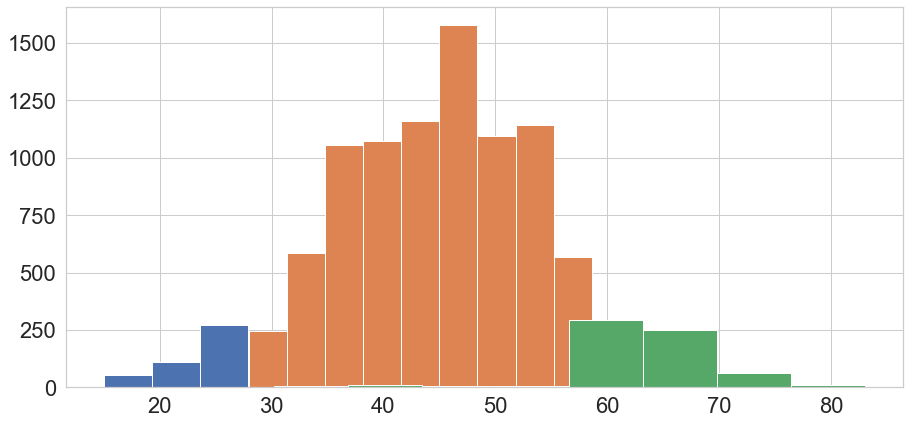

In [10]:
control = experiment.query("experiment_group == 'control'") \
                    .groupby('district') \
                    ['delivery_time'].hist()

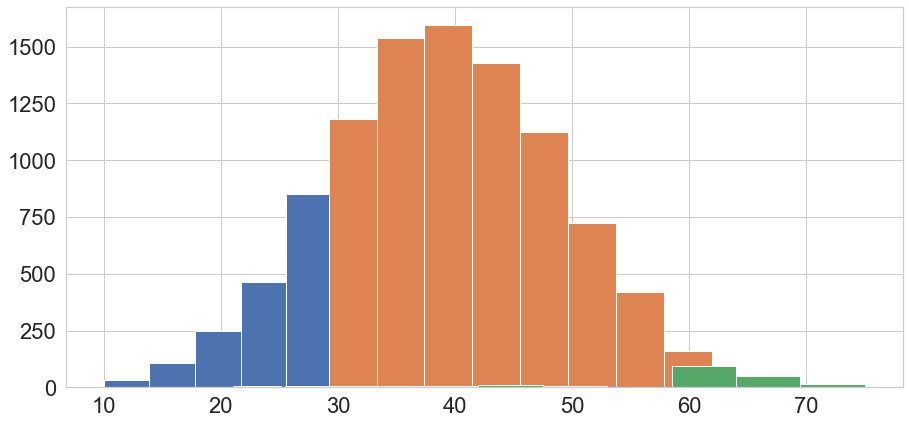

In [11]:
test = experiment.query("experiment_group == 'test'") \
                    .groupby('district') \
                    ['delivery_time'].hist()

Посчитаем количество наблюдений в тестовой и контрольной группе.На сколько по модулю отличается количество наблюдений в тесте и контроле?

In [18]:
amount_control = experiment.query("experiment_group == 'control'").shape[0]
amount_test = experiment.query("experiment_group == 'test'").shape[0]
diff = amount_test - amount_control

print('Количество наблюдений в контрольной группе: \t', amount_control)
print('Количество наблюдений в тестовой группе: \t', amount_test)
print('Разница в наблюдениях: \t', diff)

Количество наблюдений в контрольной группе: 	 10092
Количество наблюдений в тестовой группе: 	 10104
Разница в наблюдениях: 	 12


Изучим наши распределения. Проверим выполнение условий на нормальность и посчитаем стандартное отклонение в тесте и в контроле.

In [19]:
control = experiment.query("experiment_group == 'control'")
test = experiment.query("experiment_group == 'test'")

#семплируем перед тестом Шапиро-Уилка, так как выборка довольно большая
test = experiment[experiment['experiment_group'] == 'test']['delivery_time'].sample(1000, random_state=17)
control = experiment[experiment['experiment_group'] == 'control']['delivery_time'].sample(1000, random_state=17)

In [24]:
print('Контрольная группа группа:')
print(st.shapiro(control))
print('Стандартное отклонение: \t', round(np.std(experiment.query("experiment_group == 'control'") \
                                                           .delivery_time), 2))

Контрольная группа группа:
ShapiroResult(statistic=0.9974725842475891, pvalue=0.12411931157112122)
Стандартное отклонение: 	 9.99


In [23]:
print('Тестовая группа:')
print(st.shapiro(test))
print('Стандартное отклонение: \t', round(np.std(experiment.query("experiment_group == 'test'") \
                                                           .delivery_time), 2))

Тестовая группа:
ShapiroResult(statistic=0.9975475668907166, pvalue=0.14005419611930847)
Стандартное отклонение: 	 9.88


Тест Шапиро-Уилка показал, что значения в тестовой группе распределены 
нормально. В контрольной группе распределение также является нормальным. Стандартное отклонение времени доставки в тесте равно 9.88. Стандартное отклонение времени доставки в контроле равно 9.99.

Сравним средние в тесте и контроле.

In [25]:
control = experiment.query("experiment_group == 'control'").delivery_time
test = experiment.query("experiment_group == 'test'").delivery_time
st.ttest_ind(control, test)

Ttest_indResult(statistic=43.03582663183714, pvalue=0.0)

По результатам t-теста p-value < 0.05, поэтому отклоняем нулевую гипотезу о равенстве средних.

Посчитаем, на сколько процентов изменилось среднее время доставки в тестовой группе по сравнению с контрольной.

In [115]:
#test.mean() - x
#control.mean() - 100

In [28]:
answer = round((test.mean() * 100 / control.mean()) - 100, 2)
print('Среднее время доставки в тестовой группе изменилось на {} процентов по сравнению с контрольной'.format(answer))

Среднее время доставки в тестовой группе изменилось на -13.35 процентов по сравнению с контрольной


**Вывод**: согласно t-тесту новая фича статистически достоверно снизила время доставки на 13%, поэтому раскатываем новый алгоритм на всех пользователей.